In [2]:
import pandas as pd 
import numpy as np 
from textblob import TextBlob
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


import json, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import gensim


import random
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
#df = pd.read_excel('Resultados Touchpoint APP Personas del 1abr al 24 May.xlsx')
df = pd.read_excel('Touchpoint APP Personas 1 May al 8 Ago Prepago.xlsx')
df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
0,Fecha de inicio,Fecha de finalización,Tipo de respuesta,Dirección IP,Progreso,Duración (en segundos),Finalizado,Fecha registrada,ID de respuesta,Apellido del destinatario,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
1,2021-05-01 00:01:09,2021-05-01 00:02:59,IP Address,181.78.16.235,100,110,True,2021-05-01 00:02:59.714000,R_3ISGyOV01BzngPO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-04-30 00:08:19,2021-04-30 00:10:59,IP Address,191.156.153.227,38,160,False,2021-05-01 00:11:00.156000,R_22t2EpjmNZEoqFT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-04-30 00:10:51,2021-04-30 00:11:03,IP Address,181.78.21.213,6,11,False,2021-05-01 00:11:04.303000,R_2y9PPrBZcRkKcoZ,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-05-01 00:14:21,2021-05-01 00:15:37,IP Address,181.53.12.201,100,76,True,2021-05-01 00:15:38.223000,R_udHanua3i8beZtT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df.drop([0], axis=0)
df

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
1,2021-05-01 00:01:09,2021-05-01 00:02:59,IP Address,181.78.16.235,100,110,True,2021-05-01 00:02:59.714000,R_3ISGyOV01BzngPO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-04-30 00:08:19,2021-04-30 00:10:59,IP Address,191.156.153.227,38,160,False,2021-05-01 00:11:00.156000,R_22t2EpjmNZEoqFT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-04-30 00:10:51,2021-04-30 00:11:03,IP Address,181.78.21.213,6,11,False,2021-05-01 00:11:04.303000,R_2y9PPrBZcRkKcoZ,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-05-01 00:14:21,2021-05-01 00:15:37,IP Address,181.53.12.201,100,76,True,2021-05-01 00:15:38.223000,R_udHanua3i8beZtT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-04-30 00:16:38,2021-04-30 00:16:47,IP Address,181.55.225.31,6,8,False,2021-05-01 00:16:48.490000,R_pi1N5OEgj4shabD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48048,2021-08-08 23:39:41,2021-08-08 23:40:38,IP Address,181.51.32.254,100,56,True,2021-08-08 23:40:38.430000,R_sToi9iywAO42BRn,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48049,2021-08-08 23:40:25,2021-08-08 23:43:02,IP Address,181.78.12.127,100,157,True,2021-08-08 23:43:03.328000,R_3kugDTodOoTWqZe,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48050,2021-08-08 23:40:35,2021-08-08 23:43:18,IP Address,191.102.221.222,100,163,True,2021-08-08 23:43:19.277000,R_2YRIKXkrkI4ZEKr,NaN,...,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48051,2021-08-08 23:46:54,2021-08-08 23:48:20,IP Address,181.58.38.190,100,85,True,2021-08-08 23:48:20.431000,R_1fZBz7zYj4eBFWA,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.Q2_NPS_GROUP.value_counts()

Promotor     25789
Detractor     9377
Pasivo        8274
Name: Q2_NPS_GROUP, dtype: int64

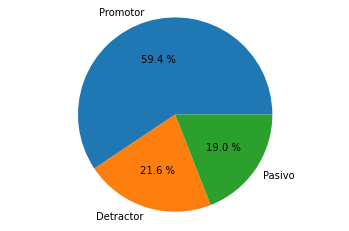

In [6]:
A = df.Q2_NPS_GROUP.value_counts()
indices = A.index
plt.pie(A, labels=indices, autopct="%0.1f %%")
plt.axis("equal")
plt.show()

In [7]:
dfc = df[df['Q2_NPS_GROUP']!='Promotor']
dfc

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
4,2021-05-01 00:14:21,2021-05-01 00:15:37,IP Address,181.53.12.201,100,76,True,2021-05-01 00:15:38.223000,R_udHanua3i8beZtT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2021-05-01 00:56:56,2021-05-01 00:58:36,IP Address,191.156.52.30,100,100,True,2021-05-01 00:58:37.141000,R_XjMcEuP3zshnpF7,NaN,...,NaN,NaN,NaN,NaN,0,5,Positive,NaN,NaN,Unknown
10,2021-05-01 01:11:12,2021-05-01 01:13:28,IP Address,190.26.155.7,100,136,True,2021-05-01 01:13:29.173000,R_x5YL4kva6EbeuWJ,NaN,...,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2021-05-01 01:15:49,2021-05-01 01:21:26,IP Address,186.29.191.43,100,336,True,2021-05-01 01:21:26.392000,R_3ltBuR7i97QbFAM,NaN,...,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,2021-05-01 01:31:59,2021-05-01 01:35:12,IP Address,191.156.2.216,100,193,True,2021-05-01 01:35:12.335000,R_1laRSYqAGwFA04C,NaN,...,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48043,2021-08-08 23:06:19,2021-08-08 23:08:27,IP Address,186.84.91.69,100,127,True,2021-08-08 23:08:27.483000,R_3qlYjnE8E36TyLC,NaN,...,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48048,2021-08-08 23:39:41,2021-08-08 23:40:38,IP Address,181.51.32.254,100,56,True,2021-08-08 23:40:38.430000,R_sToi9iywAO42BRn,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48049,2021-08-08 23:40:25,2021-08-08 23:43:02,IP Address,181.78.12.127,100,157,True,2021-08-08 23:43:03.328000,R_3kugDTodOoTWqZe,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48050,2021-08-08 23:40:35,2021-08-08 23:43:18,IP Address,191.102.221.222,100,163,True,2021-08-08 23:43:19.277000,R_2YRIKXkrkI4ZEKr,NaN,...,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
dfc = dfc[['Q4', 'Q12', 'Q15', 'Q18', 'Q20']]
dfc

,Q4,Q12,Q15,Q18,Q20
4,Ninguna,NaN,NaN,NaN,NaN
9,Cuando me quedo sin saldo no carga la app para...,NaN,NaN,NaN,Me parece bien
10,NaN,NaN,Mala señal,NaN,NaN
11,Tengo bastante tiempo con ustedes y me le subi...,NaN,Me cambié x un mes a otro operador y me regres...,NaN,NaN
13,NaN,NaN,Se demora para cargar y después dice lo siente...,Nada,NaN
...,...,...,...,...,...
48043,NaN,Antes era mas facil encontrar y hacer las cosas,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,NaN
48048,NaN,NaN,NaN,NaN,NaN
48049,NaN,NaN,NaN,NaN,NaN
48050,NaN,NaN,Bn,No lo entendí bien gracias 😊,NaN


In [9]:
dfc = dfc.fillna('')
dfc

,Q4,Q12,Q15,Q18,Q20
4,Ninguna,,,,
9,Cuando me quedo sin saldo no carga la app para...,,,,Me parece bien
10,,,Mala señal,,
11,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,
13,,,Se demora para cargar y después dice lo siente...,Nada,
...,...,...,...,...,...
48043,,Antes era mas facil encontrar y hacer las cosas,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,
48048,,,,,
48049,,,,,
48050,,,Bn,No lo entendí bien gracias 😊,


In [10]:
def limpiar_texto(texto):
    """
    Función para realizar la limpieza de un texto dado.
    """
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # Convertimos textos a minusculas
    texto = texto.lower()
    return texto

In [11]:
dfc["Tokens_Q4"] =  dfc.Q4.apply(limpiar_texto)
dfc["Tokens_Q12"] =  dfc.Q12.apply(limpiar_texto)
dfc["Tokens_Q15"] =  dfc.Q15.apply(limpiar_texto)
dfc["Tokens_Q18"] =  dfc.Q18.apply(limpiar_texto)
dfc["Tokens_Q20"] =  dfc.Q20.apply(limpiar_texto)
dfc

,Q4,Q12,Q15,Q18,Q20,Tokens_Q4,Tokens_Q12,Tokens_Q15,Tokens_Q18,Tokens_Q20
4,Ninguna,,,,,ninguna,,,,
9,Cuando me quedo sin saldo no carga la app para...,,,,Me parece bien,cuando me quedo sin saldo no carga la app para...,,,,me parece bien
10,,,Mala señal,,,,,mala señal,,
11,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,,tengo bastante tiempo con ustedes me le subier...,,me cambié un mes otro operador me regrese de n...,,
13,,,Se demora para cargar y después dice lo siente...,Nada,,,,se demora para cargar después dice lo sienten ...,nada,
...,...,...,...,...,...,...,...,...,...,...
48043,,Antes era mas facil encontrar y hacer las cosas,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,,,antes era mas facil encontrar hacer las cosas,ya no se puede pagar la factura tampoco se pue...,no pude ver el consumo de mis datos tampoco pa...,
48048,,,,,,,,,,
48049,,,,,,,,,,
48050,,,Bn,No lo entendí bien gracias 😊,,,,bn,no lo entendí bien gracias,


In [12]:
tokenizer = ToktokTokenizer() 
dfc["Tokens_Q4"] = dfc.Tokens_Q4.apply(tokenizer.tokenize)
dfc["Tokens_Q12"] = dfc.Tokens_Q12.apply(tokenizer.tokenize)
dfc["Tokens_Q15"] = dfc.Tokens_Q15.apply(tokenizer.tokenize)
dfc["Tokens_Q18"] = dfc.Tokens_Q18.apply(tokenizer.tokenize)
dfc["Tokens_Q20"] = dfc.Tokens_Q20.apply(tokenizer.tokenize)
dfc.head()

,Q4,Q12,Q15,Q18,Q20,Tokens_Q4,Tokens_Q12,Tokens_Q15,Tokens_Q18,Tokens_Q20
4,Ninguna,,,,,[ninguna],[],[],[],[]
9,Cuando me quedo sin saldo no carga la app para...,,,,Me parece bien,"[cuando, me, quedo, sin, saldo, no, carga, la,...",[],[],[],"[me, parece, bien]"
10,,,Mala señal,,,[],[],"[mala, señal]",[],[]
11,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,,"[tengo, bastante, tiempo, con, ustedes, me, le...",[],"[me, cambié, un, mes, otro, operador, me, regr...",[],[]
13,,,Se demora para cargar y después dice lo siente...,Nada,,[],[],"[se, demora, para, cargar, después, dice, lo, ...",[nada],[]


In [13]:
import nltk
nltk.download('stopwords')

STOPWORDS = set(stopwords.words("spanish"))

def filtrar_stopword_digitos(tokens):
    """
    Filtra stopwords y digitos de una lista de tokens.
    """
    return [token for token in tokens if token not in STOPWORDS 
            and not token.isdigit()]

dfc["Tokens_Q4"] = dfc.Tokens_Q4.apply(filtrar_stopword_digitos)
dfc["Tokens_Q12"] = dfc.Tokens_Q12.apply(filtrar_stopword_digitos)
dfc["Tokens_Q15"] = dfc.Tokens_Q15.apply(filtrar_stopword_digitos)
dfc["Tokens_Q18"] = dfc.Tokens_Q18.apply(filtrar_stopword_digitos)
dfc["Tokens_Q20"] = dfc.Tokens_Q20.apply(filtrar_stopword_digitos)
dfc.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CristhianJohnatanIzq\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


,Q4,Q12,Q15,Q18,Q20,Tokens_Q4,Tokens_Q12,Tokens_Q15,Tokens_Q18,Tokens_Q20
4,Ninguna,,,,,[ninguna],[],[],[],[]
9,Cuando me quedo sin saldo no carga la app para...,,,,Me parece bien,"[quedo, saldo, carga, app, poder, recargar, vez]",[],[],[],"[parece, bien]"
10,,,Mala señal,,,[],[],"[mala, señal]",[],[]
11,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,,"[bastante, tiempo, ustedes, subieron, plan, li...",[],"[cambié, mes, operador, regrese, nuevo, subier...",[],[]
13,,,Se demora para cargar y después dice lo siente...,Nada,,[],[],"[demora, cargar, después, dice, sienten, traba...",[],[]


In [14]:
stemmer = SnowballStemmer("spanish")

def stem_palabras(tokens):
    """
    Reduce cada palabra de una lista dada a su raíz.
    """
    return [stemmer.stem(token) for token in tokens]

dfc["Tokens_Q4"] = dfc.Tokens_Q4.apply(stem_palabras)
dfc["Tokens_Q12"] = dfc.Tokens_Q12.apply(stem_palabras)
dfc["Tokens_Q15"] = dfc.Tokens_Q15.apply(stem_palabras)
dfc["Tokens_Q18"] = dfc.Tokens_Q18.apply(stem_palabras)
dfc["Tokens_Q20"] = dfc.Tokens_Q20.apply(stem_palabras)
dfc.head()

,Q4,Q12,Q15,Q18,Q20,Tokens_Q4,Tokens_Q12,Tokens_Q15,Tokens_Q18,Tokens_Q20
4,Ninguna,,,,,[ningun],[],[],[],[]
9,Cuando me quedo sin saldo no carga la app para...,,,,Me parece bien,"[qued, sald, carg, app, pod, recarg, vez]",[],[],[],"[parec, bien]"
10,,,Mala señal,,,[],[],"[mal, señal]",[],[]
11,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,,"[bastant, tiemp, usted, sub, plan, line]",[],"[cambi, mes, oper, regres, nuev, sub, mil, pes...",[],[]
13,,,Se demora para cargar y después dice lo siente...,Nada,,[],[],"[demor, carg, despues, dic, sient, trabaj, ser...",[],[]


In [15]:
list_Q4 = dfc["Tokens_Q4"].tolist()
list_Q12 = dfc["Tokens_Q12"].tolist()
list_Q15 = dfc["Tokens_Q15"].tolist()
list_Q18 = dfc["Tokens_Q18"].tolist()
list_Q20 = dfc["Tokens_Q20"].tolist()

list_Q4 = [x for x in list_Q4 if x!= []]
list_Q12 = [x for x in list_Q12 if x!= []]
list_Q15 = [x for x in list_Q15 if x!= []]
list_Q18 = [x for x in list_Q18 if x!= []]
list_Q20 = [x for x in list_Q20 if x!= []]

In [16]:
#list_Q15

In [17]:
Lista_general = list_Q4+list_Q12+list_Q15+list_Q18
#print(Lista_general)

In [20]:
bigram = gensim.models.Phrases(Lista_general, min_count=5, threshold=10) 
trigram = gensim.models.Phrases(bigram[Lista_general], threshold=10)  


bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[Lista_general[15]]])

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

['mal', 'servici']


In [19]:
bigram

In [21]:
data_words_bigrams = make_bigrams(Lista_general)

In [22]:
diccionario = Dictionary(data_words_bigrams)
print(f'Número de tokens: {len(diccionario)}')

Número de tokens: 4664


In [24]:
print(diccionario)

Dictionary(4664 unique tokens: ['ningun', 'app', 'carg', 'pod', 'qued']...)


In [25]:
diccionario.filter_extremes(no_below=2, no_above = 0.9)
print(f'Número de tokens: {len(diccionario)}')

Número de tokens: 2197


In [27]:
print(diccionario)

Dictionary(2197 unique tokens: ['ningun', 'app', 'carg', 'pod', 'qued']...)


In [30]:
corpus = [diccionario.doc2bow(noticia) for noticia in data_words_bigrams]
# Mostramos el BOW de una noticia
print(corpus[6])

[(23, 1)]


In [31]:
lda = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=9, random_state=35, 
               chunksize=1000, iterations=200, passes=40, alpha='auto')

In [32]:
topicos = lda.print_topics(num_words=5, num_topics=20)
for topico in topicos:
    print(topico)

(0, '0.120*"dat" + 0.113*"internet" + 0.103*"mal" + 0.080*"lent" + 0.068*"señal"')
(1, '0.080*"sald" + 0.061*"activ" + 0.045*"paquet" + 0.031*"revis" + 0.027*"dias"')
(2, '0.105*"hac" + 0.088*"recarg" + 0.054*"pod" + 0.046*"realiz" + 0.030*"wifi"')
(3, '0.105*"funcion" + 0.058*"nunc" + 0.038*"pas" + 0.034*"acced" + 0.026*"facil"')
(4, '0.154*"pud" + 0.121*"registr" + 0.098*"equip" + 0.064*"compr" + 0.041*"ningun"')
(5, '0.102*"dej" + 0.100*"pued" + 0.086*"app" + 0.078*"ver" + 0.069*"ingres"')
(6, '0.202*"pag" + 0.150*"factur" + 0.126*"servici" + 0.035*"sirv" + 0.031*"sal"')
(7, '0.068*"plan" + 0.052*"clar" + 0.048*"consult" + 0.042*"cuent" + 0.037*"clar_hog"')
(8, '0.107*"aplic" + 0.070*"llam" + 0.053*"carg" + 0.046*"telefon" + 0.044*"asesor"')


In [31]:
import pyLDAvis.gensim_models

lda_display = pyLDAvis.gensim_models.prepare(lda, corpus, diccionario, sort_topics=False)
pyLDAvis.display(lda_display)

In [35]:
lda_5 = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=5, random_state=35, 
               chunksize=1000, iterations=200, passes=40, alpha='auto')

In [36]:
import pyLDAvis.gensim_models

lda_display = pyLDAvis.gensim_models.prepare(lda_5, corpus, diccionario, sort_topics=False)
pyLDAvis.display(lda_display)

In [37]:
lda_4 = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=4, random_state=35, 
               chunksize=1000, iterations=200, passes=40, alpha='auto')

In [35]:
import pyLDAvis.gensim_models

lda_display = pyLDAvis.gensim_models.prepare(lda_4, corpus, diccionario, sort_topics=False)
pyLDAvis.display(lda_display)

In [38]:
pyLDAvis.save_html(lda_display, 'lda_General_4_V3.html')
lda_4.save('Lda_4_Model')

In [39]:
lda_prueba = LdaModel.load('Lda_4_Model')

In [40]:
dfc2 = df[df['Q2_NPS_GROUP']!='Promotor']
dfc2 = dfc.fillna('')
dfc2

,Q4,Q12,Q15,Q18,Q20,Tokens_Q4,Tokens_Q12,Tokens_Q15,Tokens_Q18,Tokens_Q20
4,Ninguna,,,,,[ningun],[],[],[],[]
9,Cuando me quedo sin saldo no carga la app para...,,,,Me parece bien,"[qued, sald, carg, app, pod, recarg, vez]",[],[],[],"[parec, bien]"
10,,,Mala señal,,,[],[],"[mal, señal]",[],[]
11,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,,"[bastant, tiemp, usted, sub, plan, line]",[],"[cambi, mes, oper, regres, nuev, sub, mil, pes...",[],[]
13,,,Se demora para cargar y después dice lo siente...,Nada,,[],[],"[demor, carg, despues, dic, sient, trabaj, ser...",[],[]
...,...,...,...,...,...,...,...,...,...,...
48043,,Antes era mas facil encontrar y hacer las cosas,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,,[],"[mas, facil, encontr, hac, cos]","[pued, pag, factur, tampoc, pued, ver, consum,...","[pud, ver, consum, dat, tampoc, pag, factur]",[]
48048,,,,,,[],[],[],[],[]
48049,,,,,,[],[],[],[],[]
48050,,,Bn,No lo entendí bien gracias 😊,,[],[],[bn],"[entend, bien, graci]",[]


In [41]:
def Limpiar_Caracter(texto):
    if len(texto) == 1 or texto == ',':
        texto = ''
    else:
        texto = texto
    return texto

In [42]:
dfc2["Tokens_Q4"] =  dfc2.Q4.apply(limpiar_texto)
dfc2["Tokens_Q12"] =  dfc2.Q12.apply(limpiar_texto)
dfc2["Tokens_Q15"] =  dfc2.Q15.apply(limpiar_texto)
dfc2["Tokens_Q18"] =  dfc2.Q18.apply(limpiar_texto)
dfc2["Tokens_Q20"] =  dfc2.Q20.apply(limpiar_texto)

dfc2["Tokens_Q4"] =  dfc2.Q4.apply(Limpiar_Caracter)
dfc2["Tokens_Q12"] =  dfc2.Q12.apply(Limpiar_Caracter)
dfc2["Tokens_Q15"] =  dfc2.Q15.apply(Limpiar_Caracter)
dfc2["Tokens_Q18"] =  dfc2.Q18.apply(Limpiar_Caracter)
dfc2["Tokens_Q20"] =  dfc2.Q20.apply(Limpiar_Caracter)

dfc2

,Q4,Q12,Q15,Q18,Q20,Tokens_Q4,Tokens_Q12,Tokens_Q15,Tokens_Q18,Tokens_Q20
4,Ninguna,,,,,Ninguna,,,,
9,Cuando me quedo sin saldo no carga la app para...,,,,Me parece bien,Cuando me quedo sin saldo no carga la app para...,,,,Me parece bien
10,,,Mala señal,,,,,Mala señal,,
11,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,
13,,,Se demora para cargar y después dice lo siente...,Nada,,,,Se demora para cargar y después dice lo siente...,Nada,
...,...,...,...,...,...,...,...,...,...,...
48043,,Antes era mas facil encontrar y hacer las cosas,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,,,Antes era mas facil encontrar y hacer las cosas,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,
48048,,,,,,,,,,
48049,,,,,,,,,,
48050,,,Bn,No lo entendí bien gracias 😊,,,,Bn,No lo entendí bien gracias 😊,


In [50]:
dfc2['Opinion'] = ''

for i in dfc2.index:
    dfc2.loc[i,'Opinion'] = str(dfc2.loc[i,'Tokens_Q12']) + " " + str(dfc2.loc[i,'Tokens_Q15']) + " " + str(dfc2.loc[i,'Tokens_Q18']) 
    
dfc2

,Q4,Q12,Q15,Q18,Q20,Tokens_Q4,Tokens_Q12,Tokens_Q15,Tokens_Q18,Tokens_Q20,Opinion
4,Ninguna,,,,,Ninguna,,,,,
9,Cuando me quedo sin saldo no carga la app para...,,,,Me parece bien,Cuando me quedo sin saldo no carga la app para...,,,,Me parece bien,
10,,,Mala señal,,,,,Mala señal,,,Mala señal
11,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,,Me cambié x un mes a otro operador y me regre...
13,,,Se demora para cargar y después dice lo siente...,Nada,,,,Se demora para cargar y después dice lo siente...,Nada,,Se demora para cargar y después dice lo sient...
...,...,...,...,...,...,...,...,...,...,...,...
48043,,Antes era mas facil encontrar y hacer las cosas,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,,,Antes era mas facil encontrar y hacer las cosas,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,,Antes era mas facil encontrar y hacer las cosa...
48048,,,,,,,,,,,
48049,,,,,,,,,,,
48050,,,Bn,No lo entendí bien gracias 😊,,,,Bn,No lo entendí bien gracias 😊,,Bn No lo entendí bien gracias 😊


In [51]:
dfc2['Opinion'] = dfc2['Opinion'].apply(tokenizer.tokenize)
dfc2['Opinion'] = dfc2['Opinion'].apply(filtrar_stopword_digitos)
dfc2['Opinion'] = dfc2['Opinion'].apply(stem_palabras)
dfc2['Opinion'] 

4                                                       []
9                                                       []
10                                            [mal, señal]
11       [me, cambi, x, mes, oper, regres, nuev, sub, m...
13       [se, demor, carg, despues, dic, sient, trabaj,...
                               ...                        
48043    [antes, mas, facil, encontr, hac, cos, ya, pue...
48048                                                   []
48049                                                   []
48050                     [bn, no, entend, bien, graci, 😊]
48052            [es, lent, app, se, demor, entrar, aplic]
Name: Opinion, Length: 22263, dtype: object

In [53]:
for i in dfc2.index:
    
    if dfc2.loc[i,'Opinion']==[]:
        dfc2.drop([i], inplace=True)

dfc2

,Q4,Q12,Q15,Q18,Q20,Tokens_Q4,Tokens_Q12,Tokens_Q15,Tokens_Q18,Tokens_Q20,Opinion
10,,,Mala señal,,,,,Mala señal,,,"[mal, señal]"
11,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,,"[me, cambi, x, mes, oper, regres, nuev, sub, m..."
13,,,Se demora para cargar y después dice lo siente...,Nada,,,,Se demora para cargar y después dice lo siente...,Nada,,"[se, demor, carg, despues, dic, sient, trabaj,..."
27,,No muestra mi linea,No aparecen datos de mi línea consultada 31323...,No pide consultar nada acerca de mi línea 3132...,,,No muestra mi linea,No aparecen datos de mi línea consultada 31323...,No pide consultar nada acerca de mi línea 3132...,,"[no, muestr, line, no, aparec, dat, line, cons..."
32,,,Jjjjj,,,,,Jjjjj,,,[jjjjj]
...,...,...,...,...,...,...,...,...,...,...,...
48041,Los planes versus la competencia son muy costo...,,Llevo varios meses tratando de que me den un m...,,,Los planes versus la competencia son muy costo...,,Llevo varios meses tratando de que me den un m...,,,"[llev, vari, mes, trat, den, mejor, preci, pla..."
48042,No aparece factura de agosto para 3102177480,,,No me aparece factura para el 3102177480 de ag...,,No aparece factura de agosto para 3102177480,,,No me aparece factura para el 3102177480 de ag...,,"[no, aparec, factur, agost]"
48043,,Antes era mas facil encontrar y hacer las cosas,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,,,Antes era mas facil encontrar y hacer las cosas,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,,"[antes, mas, facil, encontr, hac, cos, ya, pue..."
48050,,,Bn,No lo entendí bien gracias 😊,,,,Bn,No lo entendí bien gracias 😊,,"[bn, no, entend, bien, graci, 😊]"


In [56]:
diccionario.doc2bow(dfc2.loc[10,'Opinion'])

[(44, 1), (54, 1)]

In [58]:
dfc2['Tópico'] = ""
for i in dfc2.index:
    try:
        
        bow_comentario = diccionario.doc2bow(dfc2.loc[i,'Opinion'])
        distribucion_noticia = lda_4[bow_comentario]

        dist_contrib = [topico[1] for topico in lda_4[bow_comentario]]

        if (dist_contrib[0] > dist_contrib[1]) & (dist_contrib[0] > dist_contrib[2]) & (dist_contrib[0] > dist_contrib[3]):
            dfc2.loc[i,'Tópico'] = 1
        elif (dist_contrib[1] > dist_contrib[0]) & (dist_contrib[1] > dist_contrib[2]) & (dist_contrib[1] > dist_contrib[3]):
            dfc2.loc[i,'Tópico'] = 2
        elif (dist_contrib[2] > dist_contrib[0]) & (dist_contrib[2] > dist_contrib[1]) & (dist_contrib[2] > dist_contrib[3]):
            dfc2.loc[i,'Tópico'] = 3
        elif (dist_contrib[3] > dist_contrib[0]) & (dist_contrib[3] > dist_contrib[1]) & (dist_contrib[3] > dist_contrib[2]):
            dfc2.loc[i,'Tópico'] = 4
        
    except:
        print('No')

In [59]:
dfc2.Tópico.value_counts()

3    6903
1     185
2      26
4      17
Name: Tópico, dtype: int64

In [60]:
dfc2

,Q4,Q12,Q15,Q18,Q20,Tokens_Q4,Tokens_Q12,Tokens_Q15,Tokens_Q18,Tokens_Q20,Opinion,Tópico
10,,,Mala señal,,,,,Mala señal,,,"[mal, señal]",3
11,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,,"[me, cambi, x, mes, oper, regres, nuev, sub, m...",3
13,,,Se demora para cargar y después dice lo siente...,Nada,,,,Se demora para cargar y después dice lo siente...,Nada,,"[se, demor, carg, despues, dic, sient, trabaj,...",3
27,,No muestra mi linea,No aparecen datos de mi línea consultada 31323...,No pide consultar nada acerca de mi línea 3132...,,,No muestra mi linea,No aparecen datos de mi línea consultada 31323...,No pide consultar nada acerca de mi línea 3132...,,"[no, muestr, line, no, aparec, dat, line, cons...",3
32,,,Jjjjj,,,,,Jjjjj,,,[jjjjj],3
...,...,...,...,...,...,...,...,...,...,...,...,...
48041,Los planes versus la competencia son muy costo...,,Llevo varios meses tratando de que me den un m...,,,Los planes versus la competencia son muy costo...,,Llevo varios meses tratando de que me den un m...,,,"[llev, vari, mes, trat, den, mejor, preci, pla...",3
48042,No aparece factura de agosto para 3102177480,,,No me aparece factura para el 3102177480 de ag...,,No aparece factura de agosto para 3102177480,,,No me aparece factura para el 3102177480 de ag...,,"[no, aparec, factur, agost]",3
48043,,Antes era mas facil encontrar y hacer las cosas,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,,,Antes era mas facil encontrar y hacer las cosas,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,,"[antes, mas, facil, encontr, hac, cos, ya, pue...",3
48050,,,Bn,No lo entendí bien gracias 😊,,,,Bn,No lo entendí bien gracias 😊,,"[bn, no, entend, bien, graci, 😊]",3


In [61]:
dfc2['RecordedDate'] = df['RecordedDate']
dfc2['Q2_NPS_GROUP'] = df['Q2_NPS_GROUP']
dfc2['Q2'] = df['Q2']
dfc2['Q3'] = df['Q3']
dfc2['Q9'] = df['Q9']
dfc2['Q11'] = df['Q11']
dfc2['Nombre del cliente App'] = df['Nombre del cliente App']
dfc2['ID cuenta o Telefono App'] = df['ID cuenta o Telefono App']
dfc2['email App'] = df['email App']
dfc2['Segmento App'] = df['Segmento App']
dfc2['Modulo App'] = df['Modulo App']

In [62]:
dfc2

,Q4,Q12,Q15,Q18,Q20,Tokens_Q4,Tokens_Q12,Tokens_Q15,Tokens_Q18,Tokens_Q20,...,Q2_NPS_GROUP,Q2,Q3,Q9,Q11,Nombre del cliente App,ID cuenta o Telefono App,email App,Segmento App,Modulo App
10,,,Mala señal,,,,,Mala señal,,,...,Detractor,5,El funcionamiento de la app,NaN,La facilidad para descargar la app,Heyder Mesa Prieto,3144597332,heidermesa@hotmail.com,pre,pre_detalle_plan
11,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,,Tengo bastante tiempo con ustedes y me le subi...,,Me cambié x un mes a otro operador y me regres...,,,...,Detractor,5,Otras razones,NaN,NaN,Maria Elvi Acero Gonzalez,3114559290,elviraacero14@gmail.com,pre,pre_elegidos
13,,,Se demora para cargar y después dice lo siente...,Nada,,,,Se demora para cargar y después dice lo siente...,Nada,,...,Detractor,0,El funcionamiento de la app,NaN,Rapidez de la aplicación,Jerson Steven Builes Castrillon,3117710110,yozmansbc@gmail.com,pre,pre_consulta_saldo
27,,No muestra mi linea,No aparecen datos de mi línea consultada 31323...,No pide consultar nada acerca de mi línea 3132...,,,No muestra mi linea,No aparecen datos de mi línea consultada 31323...,No pide consultar nada acerca de mi línea 3132...,,...,Detractor,0,El funcionamiento de la app,NaN,Por otras razones,Omar Jairo Moreno Hernandez,3132339396,prensaenmoto@gmail.com,pre,pre_consulta_saldo
32,,,Jjjjj,,,,,Jjjjj,,,...,Detractor,1,El registro o ingreso a la app,Por otras razones,NaN,Robinson Butron Alian,3226216529,solucionesgenco@gmail.com,pre,pre_detalle_plan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48041,Los planes versus la competencia son muy costo...,,Llevo varios meses tratando de que me den un m...,,,Los planes versus la competencia son muy costo...,,Llevo varios meses tratando de que me den un m...,,,...,Detractor,5,Otras razones,NaN,NaN,Yeimy Milena Diaz Jimenez,3102624152,mileosanwo@gmail.com,pre,pre_gestionar_equipo
48042,No aparece factura de agosto para 3102177480,,,No me aparece factura para el 3102177480 de ag...,,No aparece factura de agosto para 3102177480,,,No me aparece factura para el 3102177480 de ag...,,...,Pasivo,8,Otras razones,NaN,NaN,Paulina Zambrano Diaz,3102177480,dentalceramica@yahoo.es,pre,pre_detalle_plan
48043,,Antes era mas facil encontrar y hacer las cosas,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,,,Antes era mas facil encontrar y hacer las cosas,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,,...,Detractor,1,El funcionamiento de la app,NaN,Por otras razones,Maria Paula Cardona Lozano,3224311507,cardonapaula191@gmail.com,pre,pre_consulta_saldo
48050,,,Bn,No lo entendí bien gracias 😊,,,,Bn,No lo entendí bien gracias 😊,,...,Detractor,6,"El registro o ingreso a la app,El funcionamien...","La facilidad para registrarte,La facilidad par...","La facilidad para descargar la app,La facilida...",Prospero Guillermo Coronado Cantillo,3126177396,prosperocoronado30@gmail.com,pre,pre_elegidos


In [63]:
lista_ordenada = ['RecordedDate', 'Q2_NPS_GROUP', 'Q2', 'Q3', 'Q4', 'Q9', 'Q12', 'Q11', 'Q15', 'Q18', 'Q20', 'Opinion', 'Tópico', 'Segmento App', 'Modulo App', 'Nombre del cliente App', 'ID cuenta o Telefono App', 'email App', 'Segmento App']
dfc2 = dfc2[lista_ordenada]
dfc2

,RecordedDate,Q2_NPS_GROUP,Q2,Q3,Q4,Q9,Q12,Q11,Q15,Q18,Q20,Opinion,Tópico,Segmento App,Modulo App,Nombre del cliente App,ID cuenta o Telefono App,email App,Segmento App
10,2021-05-01 01:13:29.173000,Detractor,5,El funcionamiento de la app,,NaN,,La facilidad para descargar la app,Mala señal,,,"[mal, señal]",3,pre,pre_detalle_plan,Heyder Mesa Prieto,3144597332,heidermesa@hotmail.com,pre
11,2021-05-01 01:21:26.392000,Detractor,5,Otras razones,Tengo bastante tiempo con ustedes y me le subi...,NaN,,NaN,Me cambié x un mes a otro operador y me regres...,,,"[me, cambi, x, mes, oper, regres, nuev, sub, m...",3,pre,pre_elegidos,Maria Elvi Acero Gonzalez,3114559290,elviraacero14@gmail.com,pre
13,2021-05-01 01:35:12.335000,Detractor,0,El funcionamiento de la app,,NaN,,Rapidez de la aplicación,Se demora para cargar y después dice lo siente...,Nada,,"[se, demor, carg, despues, dic, sient, trabaj,...",3,pre,pre_consulta_saldo,Jerson Steven Builes Castrillon,3117710110,yozmansbc@gmail.com,pre
27,2021-05-01 05:46:19.079000,Detractor,0,El funcionamiento de la app,,NaN,No muestra mi linea,Por otras razones,No aparecen datos de mi línea consultada 31323...,No pide consultar nada acerca de mi línea 3132...,,"[no, muestr, line, no, aparec, dat, line, cons...",3,pre,pre_consulta_saldo,Omar Jairo Moreno Hernandez,3132339396,prensaenmoto@gmail.com,pre
32,2021-05-01 06:03:56.409000,Detractor,1,El registro o ingreso a la app,,Por otras razones,,NaN,Jjjjj,,,[jjjjj],3,pre,pre_detalle_plan,Robinson Butron Alian,3226216529,solucionesgenco@gmail.com,pre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48041,2021-08-08 23:05:23.967000,Detractor,5,Otras razones,Los planes versus la competencia son muy costo...,NaN,,NaN,Llevo varios meses tratando de que me den un m...,,,"[llev, vari, mes, trat, den, mejor, preci, pla...",3,pre,pre_gestionar_equipo,Yeimy Milena Diaz Jimenez,3102624152,mileosanwo@gmail.com,pre
48042,2021-08-08 23:07:34.573000,Pasivo,8,Otras razones,No aparece factura de agosto para 3102177480,NaN,,NaN,,No me aparece factura para el 3102177480 de ag...,,"[no, aparec, factur, agost]",3,pre,pre_detalle_plan,Paulina Zambrano Diaz,3102177480,dentalceramica@yahoo.es,pre
48043,2021-08-08 23:08:27.483000,Detractor,1,El funcionamiento de la app,,NaN,Antes era mas facil encontrar y hacer las cosas,Por otras razones,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,,"[antes, mas, facil, encontr, hac, cos, ya, pue...",3,pre,pre_consulta_saldo,Maria Paula Cardona Lozano,3224311507,cardonapaula191@gmail.com,pre
48050,2021-08-08 23:43:19.277000,Detractor,6,"El registro o ingreso a la app,El funcionamien...",,"La facilidad para registrarte,La facilidad par...",,"La facilidad para descargar la app,La facilida...",Bn,No lo entendí bien gracias 😊,,"[bn, no, entend, bien, graci, 😊]",3,pre,pre_elegidos,Prospero Guillermo Coronado Cantillo,3126177396,prosperocoronado30@gmail.com,pre


In [64]:
dfc2['Tema'] = dfc2['Tópico'] 

In [65]:
dfc2

,RecordedDate,Q2_NPS_GROUP,Q2,Q3,Q4,Q9,Q12,Q11,Q15,Q18,Q20,Opinion,Tópico,Segmento App,Modulo App,Nombre del cliente App,ID cuenta o Telefono App,email App,Segmento App,Tema
10,2021-05-01 01:13:29.173000,Detractor,5,El funcionamiento de la app,,NaN,,La facilidad para descargar la app,Mala señal,,,"[mal, señal]",3,pre,pre_detalle_plan,Heyder Mesa Prieto,3144597332,heidermesa@hotmail.com,pre,3
11,2021-05-01 01:21:26.392000,Detractor,5,Otras razones,Tengo bastante tiempo con ustedes y me le subi...,NaN,,NaN,Me cambié x un mes a otro operador y me regres...,,,"[me, cambi, x, mes, oper, regres, nuev, sub, m...",3,pre,pre_elegidos,Maria Elvi Acero Gonzalez,3114559290,elviraacero14@gmail.com,pre,3
13,2021-05-01 01:35:12.335000,Detractor,0,El funcionamiento de la app,,NaN,,Rapidez de la aplicación,Se demora para cargar y después dice lo siente...,Nada,,"[se, demor, carg, despues, dic, sient, trabaj,...",3,pre,pre_consulta_saldo,Jerson Steven Builes Castrillon,3117710110,yozmansbc@gmail.com,pre,3
27,2021-05-01 05:46:19.079000,Detractor,0,El funcionamiento de la app,,NaN,No muestra mi linea,Por otras razones,No aparecen datos de mi línea consultada 31323...,No pide consultar nada acerca de mi línea 3132...,,"[no, muestr, line, no, aparec, dat, line, cons...",3,pre,pre_consulta_saldo,Omar Jairo Moreno Hernandez,3132339396,prensaenmoto@gmail.com,pre,3
32,2021-05-01 06:03:56.409000,Detractor,1,El registro o ingreso a la app,,Por otras razones,,NaN,Jjjjj,,,[jjjjj],3,pre,pre_detalle_plan,Robinson Butron Alian,3226216529,solucionesgenco@gmail.com,pre,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48041,2021-08-08 23:05:23.967000,Detractor,5,Otras razones,Los planes versus la competencia son muy costo...,NaN,,NaN,Llevo varios meses tratando de que me den un m...,,,"[llev, vari, mes, trat, den, mejor, preci, pla...",3,pre,pre_gestionar_equipo,Yeimy Milena Diaz Jimenez,3102624152,mileosanwo@gmail.com,pre,3
48042,2021-08-08 23:07:34.573000,Pasivo,8,Otras razones,No aparece factura de agosto para 3102177480,NaN,,NaN,,No me aparece factura para el 3102177480 de ag...,,"[no, aparec, factur, agost]",3,pre,pre_detalle_plan,Paulina Zambrano Diaz,3102177480,dentalceramica@yahoo.es,pre,3
48043,2021-08-08 23:08:27.483000,Detractor,1,El funcionamiento de la app,,NaN,Antes era mas facil encontrar y hacer las cosas,Por otras razones,Ya no se puede pagar la factura y tampoco se p...,No pude ver el consumo de mis datos y tampoco ...,,"[antes, mas, facil, encontr, hac, cos, ya, pue...",3,pre,pre_consulta_saldo,Maria Paula Cardona Lozano,3224311507,cardonapaula191@gmail.com,pre,3
48050,2021-08-08 23:43:19.277000,Detractor,6,"El registro o ingreso a la app,El funcionamien...",,"La facilidad para registrarte,La facilidad par...",,"La facilidad para descargar la app,La facilida...",Bn,No lo entendí bien gracias 😊,,"[bn, no, entend, bien, graci, 😊]",3,pre,pre_elegidos,Prospero Guillermo Coronado Cantillo,3126177396,prosperocoronado30@gmail.com,pre,3


In [66]:
dfc2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7131 entries, 10 to 48052
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   RecordedDate              7131 non-null   object
 1   Q2_NPS_GROUP              7054 non-null   object
 2   Q2                        7054 non-null   object
 3   Q3                        6963 non-null   object
 4   Q4                        7131 non-null   object
 5   Q9                        1574 non-null   object
 6   Q12                       7131 non-null   object
 7   Q11                       4263 non-null   object
 8   Q15                       7131 non-null   object
 9   Q18                       7131 non-null   object
 10  Q20                       7131 non-null   object
 11  Opinion                   7131 non-null   object
 12  Tópico                    7131 non-null   object
 13  Segmento App              7008 non-null   object
 14  Modulo App            

In [67]:
dfc2.to_csv('Modelamiento_Topicos_General_Consolidado.csv', index=False, sep=';')